<a href="https://colab.research.google.com/github/aballiet/UserData-Protection-Attack/blob/main/Load_dataset_INSAnonym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compute POI of different users to create a unique fingerprint

*   Transpose coordinates in a grid 
*   Find cells that contain the highest number of records per user


## Load Drive module
You will have to authenticate by providing a temporary key and browse your Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp ./drive/MyDrive/INSAnonym.zip .

## Load dataset

In [3]:
!unzip INSAnonym.zip

Archive:  INSAnonym.zip
replace challenge-dataset-time1.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [4]:
import pandas as pd
import datetime
import random

In [5]:
df = pd.read_csv('./challenge-dataset-time1.csv',
                 header=None, delimiter=r"\s+",
                 names=[ 'ID', 'Date', 'Time', 'LONGITUDE', 'LATITUDE'],
                 index_col=False, parse_dates=[['Date', 'Time']])

df.set_index('Date_Time', inplace=True)
df.sort_index(inplace=True)

## Analyzing Dataset

In [6]:
print("Nomre d'ID distincts : {}".format(len(df['ID'].unique())))
print("Nomre dE LIGNES : {}".format(len(df.index)))
print(df.describe())

Nomre d'ID distincts : 69
Nomre dE LIGNES : 34551849
                 ID     LONGITUDE      LATITUDE
count  3.455185e+07  3.455185e+07  3.455185e+07
mean   4.053062e+01  4.156421e+00  4.574998e+01
std    2.662001e+01  1.113335e+01  2.105010e+00
min    1.000000e+00 -9.777081e+01  1.470705e+01
25%    1.300000e+01  4.852867e+00  4.575517e+01
50%    4.200000e+01  4.871393e+00  4.577719e+01
75%    6.500000e+01  4.879890e+00  4.578436e+01
max    1.100000e+02  1.218053e+02  6.789427e+01


In [7]:
import matplotlib.pyplot as plt
import numpy as np

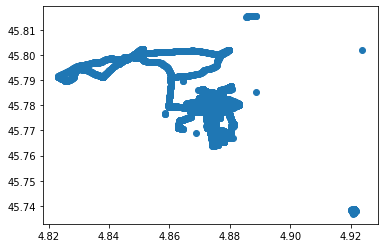

In [8]:
USER_ID = 44
plt.scatter(x=df[df.ID == USER_ID]['LONGITUDE'], y=df[df.ID == USER_ID]['LATITUDE'])
plt.show()

## Compute POI

In [9]:
# import Counter to find duplicated tuples
from collections import Counter

USERS = df['ID'].unique()

# define scale
grid_definition = 1e5
nb_poi = 3

In [10]:
def createBins(df, GRID_DEFINITION):
    MIN, MAX = df['LATITUDE'].min(), df['LATITUDE'].max()

    STEP = (MAX - MIN) / GRID_DEFINITION

    latitude_grill = np.arange(MIN, MAX, STEP)
    print("Nombre de bins pour latitude {}".format(len(latitude_grill)))
    
    MIN, MAX = df['LONGITUDE'].min(), df['LONGITUDE'].max()

    STEP = (MAX - MIN) / GRID_DEFINITION

    longitude_grill = np.arange(MIN, MAX, STEP)
    print("Nombre de bins pour longitude {}".format(len(longitude_grill)))
    
    return latitude_grill, longitude_grill

In [11]:
def compute_POI(user, df_users, nb_POI=1):
    # List initialization 
    Input = list(zip(df_users[user]["new_longitude"], df_users[user]["new_latitude"]))

    list_POI = Counter(elem for elem in Input).most_common(nb_POI)
    coordinates, freq = zip(*list_POI)
    return coordinates, freq

Nombre de bins pour latitude 100000
Nombre de bins pour longitude 100000


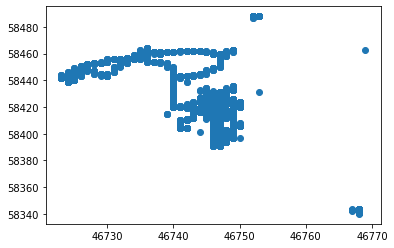

In [12]:
latitude_grill, longitude_grill = createBins(df, grid_definition)

df_users = {}

# Create dictionnay of values with converted longitude and latitude
for user in USERS:
    temp_dict = {}
    temp_dict["new_longitude"] = pd.cut(df[df.ID == user]['LONGITUDE'], bins=longitude_grill, right=True, labels=False).to_list()
    temp_dict["new_latitude"]  = pd.cut(df[df.ID == user]['LATITUDE'],  bins=latitude_grill,  right=True, labels=False).to_list()
    df_users[user] = temp_dict

# Display an example of rescaling
plt.scatter(x=df_users[USER_ID]["new_longitude"], y=df_users[USER_ID]["new_latitude"])
plt.show()

In [13]:
res  = {}
freq = {}

for user in USERS:
    res[user], freq[user] = compute_POI(user, df_users, nb_POI=nb_poi)

## Plot an example

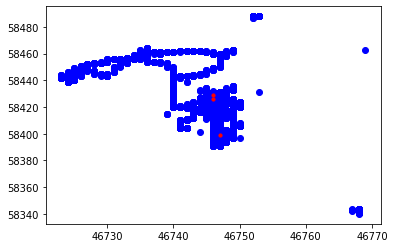

In [14]:
x = [list(t) for t in zip(*res[USER_ID])][0]
y = [list(t) for t in zip(*res[USER_ID])][1]

plt.scatter(x=df_users[USER_ID]["new_longitude"], y=df_users[USER_ID]["new_latitude"], c='b')
plt.scatter(x=x, y=y, s=10, c='r')
plt.show()

In [17]:
print("POI(s) for USER_ID {} : {} ".format(USER_ID, res[USER_ID]))
print("First POI is between : latitude {} and {}".format(latitude_grill[res[USER_ID][0][1]],
                                                         latitude_grill[res[USER_ID][0][1] + 1]))
print("Number of points in this cell : {}".format(freq[USER_ID][0]))

POI(s) for USER_ID 44 : ((46747, 58399), (46746, 58426), (46746, 58429)) 
First POI is between : latitude 45.767854194459396 and 45.7683860667094
Number of points in this cell : 102756


In [65]:
# giving a tuple, returns all the the records inside the given cell
def get_entries_in_cell(df, cell):
  latitude_filtered = df.loc[(df.LATITUDE  >= latitude_grill[cell[1]]) &
                             (df.LATITUDE <= latitude_grill[cell[1] + 1]) & (df.ID == USER_ID)]

  mask = (latitude_filtered.LONGITUDE >= longitude_grill[cell[0]]) & (latitude_filtered.LONGITUDE <= longitude_grill[cell[0]+1])
  
  return latitude_filtered[mask]

In [68]:
entries_index = get_entries_in_cell(df, res[USER_ID][0])
assert len(entries_index.index) == freq[USER_ID][0]
print("Found {} records".format(len(entries_index.index)))

Found 102756 records
